In [1]:
#macro to read the simulated data after the AI pipeline and to compare the traditional and AI tracking pipeline

In [16]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import itertools
import awkward as ak
import pandas as pd
from functions import read_root_viewx,read_root_viewy,linear_fit,lin_calc,evaluateRecoCosineDirector
import MyData as data
import root_function
import os,string,copy
import pickle

In [18]:
ly_hit_x,x_hit,zx_hit,dx_hit,pex_hit=read_root_viewx("/lustrehome/federicacuna/TB_Sept_2023_ml/root_file_predhit/pred_data_xz_NORMBALANCED_HN_SageConv.root")

5000
no good event  728
no good event  1459
no good event  3041
no good event  3129
no good event  4009
no good event  4830
no good event  4907
no good event  4957
4992


In [3]:
ly_hit_y,y_hit,zy_hit,dy_hit,pey_hit=read_root_viewy("/lustrehome/federicacuna/TB_Sept_2023_ml/root_file_predhit/pred_data_yz_NORMBALANCED_SageConv.root")

5000
5000


In [4]:
ev_to_delete_iny=[4965]#,1459,3041,3129,4009,4830,4907,4957]
sorted_listy = sorted(ev_to_delete_iny)
# print('delete no good event')
for k in  sorted_listy:   
    print(k)    
    del zy_hit[k]
    del y_hit[k]
    del dy_hit[k]
    del ly_hit_y[k]
    del pey_hit[k]
  

4965


In [38]:
# ev_to_delete_inx=[1104,4340]#,2812]#,2864,3271,4839]
# sorted_listx = sorted(ev_to_delete_inx)
# # print('delete no good event')
# for k in  sorted_listx:   
#     print(k)    
#     del pex_hit[k]
#     del ly_hit_x[k]
#     del x_hit[k]
#     del dx_hit[k]
#     del zx_hit[k]

1104
4340


In [78]:
len(pey_hit)

4999

In [5]:
%%time
ax_ev=[]
bx_ev=[]
ay_ev=[]
by_ev=[]

ax_ev,bx_ev=linear_fit(len(ly_hit_x),x_hit,zx_hit,dx_hit)
ay_ev,by_ev=linear_fit(len(ly_hit_y),y_hit,zy_hit,dy_hit)
   

CPU times: user 116 ms, sys: 5.15 ms, total: 122 ms
Wall time: 119 ms


In [37]:
#####trad pipeline

In [6]:
data=data.dataset_preparation(root='/lustrehome/federicacuna/TB_Sept_2023_ml/Data/preprocessed/')
fnamex='pi-_10GeV_4ly_1e-4_inclined_NEW_viewx'
fnamey='pi-_10GeV_4ly_1e-4_inclined_NEW_viewy'
# fnamex='pi-_10GeV_4ly_1e-4_inclined_4ly_GAT_viewx'
# fnamey='pi-_10GeV_4ly_1e-4_inclined_4ly_GAT_viewy'
data_trkx=data.get_more_file(800,801,fnamex)[:5000]
data_trky=data.get_more_file(800,801,fnamey)[:5000]

taking a list of file from  800  to  801
taking a list of file from  800  to  801


In [7]:
%%time
ly_vecx_trad=[]
x_vec_trad=[]
zx_vec_trad=[]
dx_vec_trad=[]
ly_vecy_trad=[]
y_vec_trad=[]
dy_vec_trad=[]
zy_vec_trad=[]
x_true=[]
y_true=[]
for i in range(0,len(data_trkx)):
    ly_vecx_trad.append(data_trkx[i].x[:,2].tolist())
    x_vec_trad.append(data_trkx[i].x[:,0].tolist())
    zx_vec_trad.append(data_trkx[i].x[:,3].tolist())
    dx_vec_trad.append(data_trkx[i].x[:,1].tolist())   
    ly_vecy_trad.append(data_trky[i].x[:,2].tolist())
    y_vec_trad.append(data_trky[i].x[:,0].tolist())
    zy_vec_trad.append(data_trky[i].x[:,3].tolist())
    dy_vec_trad.append(data_trky[i].x[:,1].tolist())
    x_true.append(data_trkx[i].y.tolist())
    y_true.append(data_trky[i].y.tolist())

CPU times: user 580 ms, sys: 16.1 ms, total: 596 ms
Wall time: 587 ms


In [10]:
%%time
ax_vec_trad=[]
bx_vec_trad=[]
chi2x_vec_trad=[]
for ievent in range(0,len(data_trkx)):
    a_x = -999
    b_x = -999
    chi2_x = pow(10, 9)

    nclu_x = len(ly_vecx_trad[ievent])

    xpos_x = x_vec_trad[ievent]
    xpos_error_x = dx_vec_trad[ievent]
    zpos_x = zx_vec_trad[ievent]
    planeIDs = ly_vecx_trad[ievent]
    #Find good combinations of x clusters and computer, for each of them, the track and its chi2     
    plane_set = set(planeIDs)
    n_fired_p = len(plane_set)
    cluID_combs_x = list(itertools.combinations(range(nclu_x), n_fired_p))
    for cluID_comb_x in cluID_combs_x:
        ps_comb = [planeIDs[i] for i in cluID_comb_x]

        # Check if the combination is a good one
        if len(ps_comb) == len(set(ps_comb)): 
            xpos_x_comb = ak.Array([xpos_x[i] for i in cluID_comb_x])
            xpos_error_x_comb = ak.Array([xpos_error_x[i] for i in cluID_comb_x])
            zpos_x_comb = ak.Array([zpos_x[i] for i in cluID_comb_x])
            a_x_comb,b_x_comb,chi2_x_comb=lin_calc(xpos_x_comb,xpos_error_x_comb,zpos_x_comb)
            # if ievent==317:
            #     print('x ',xpos_x_comb)
            #     print(' z ',zpos_x_comb )
            #     print('dx ',xpos_error_x_comb )
            #     print(' ',len(ps_comb))
            #     print(' ',chi2_x_comb)
            if chi2_x_comb < chi2_x:
                a_x = a_x_comb
                b_x = b_x_comb
                chi2_x = chi2_x_comb
        
    ax_vec_trad.append(a_x)
    bx_vec_trad.append(b_x)
    chi2x_vec_trad.append(chi2_x)

CPU times: user 48min 8s, sys: 59.7 s, total: 49min 8s
Wall time: 47min 38s


IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


In [11]:
with open('list_x_hn.pkl', 'wb') as f:
    pickle.dump([ax_vec_trad, bx_vec_trad, chi2x_vec_trad], f)       

In [16]:
# ax_vec_trad

In [12]:
%%time   
ay_vec_trad=[]
by_vec_trad=[]
chi2y_vec_trad=[]
for ievent in range(0,len(data_trky)):
    a_y = -999
    b_y = -999
    chi2_y = pow(10, 9)

    nclu_y = len(ly_vecy_trad[ievent])

    ypos_y = y_vec_trad[ievent]
    ypos_error_y = dy_vec_trad[ievent]
    zpos_y = zy_vec_trad[ievent]
    planeIDs = ly_vecy_trad[ievent]
    #Find good combinations of x clusters and computer, for each of them, the track and its chi2     
    plane_set = set(planeIDs)
    n_fired_p = len(plane_set)
    cluID_combs_y = list(itertools.combinations(range(nclu_y), n_fired_p))
    for cluID_comb_y in cluID_combs_y:
        ps_comb = [planeIDs[i] for i in cluID_comb_y]
        # Check if the combination is a good one
        if len(ps_comb) == len(set(ps_comb)): 
            ypos_y_comb = ak.Array([ypos_y[i] for i in cluID_comb_y])
            ypos_error_y_comb = ak.Array([ypos_error_y[i] for i in cluID_comb_y])
            zpos_y_comb = ak.Array([zpos_y[i] for i in cluID_comb_y])
            # print('event ',ievent)
            a_y_comb,b_y_comb,chi2_y_comb=lin_calc(ypos_y_comb,ypos_error_y_comb,zpos_y_comb)
            if chi2_y_comb < chi2_y:
                a_y = a_y_comb
                b_y = b_y_comb
                chi2_y = chi2_y_comb
    ay_vec_trad.append(a_y)
    by_vec_trad.append(b_y)
    chi2y_vec_trad.append(chi2_y)
    # print(chi2_x)
    # print(a_x)
    # print(b_x)

CPU times: user 55min 7s, sys: 1min 11s, total: 56min 19s
Wall time: 54min 44s


IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


In [14]:
with open('list_y_hn.pkl', 'wb') as f:
    pickle.dump([ay_vec_trad, by_vec_trad, chi2y_vec_trad], f)       

In [8]:
with open('list_x.pkl', 'rb') as f:
    ax_vec_trad, bx_vec_trad, chi2x_vec_trad = pickle.load(f)
with open('list_y.pkl', 'rb') as f:
    ay_vec_trad, by_vec_trad, chi2y_vec_trad = pickle.load(f)

In [9]:
###################################extract the cosine direct

In [9]:
crx_trad=[]
cry_trad=[]
crz_trad=[]
for i in range(len(ax_vec_trad)):    
    crx_tr,cry_tr,crz_tr=(evaluateRecoCosineDirector(ax_vec_trad[i],ay_vec_trad[i]))                         
    crx_trad.append(crx_tr)
    cry_trad.append(cry_tr)
    crz_trad.append(crz_tr)
    
crx=[]
cry=[]
crz=[]
for i in range(len(ax_ev)):
    crx_,cry_,crz_=(evaluateRecoCosineDirector(ax_ev[i],ay_ev[i]))
    crx.append(crx_)
    cry.append(cry_)
    crz.append(crz_)

In [11]:
##########plot the results to compare 

In [46]:
ROOT.gStyle.SetOptStat(1111)
chi2x_ev=[]
hchix=ROOT.TH1F("hchix","hchix",100,-0.5,999.5)
hchix.GetXaxis().SetTitle('#chi^{2}')
hchix.GetYaxis().SetTitle('Entries')
hchix.SetTitle('#chi^{2} distribution (xz view)')
hchix.SetLineColor(ROOT.kGreen+3)
hchix.SetMarkerColor(ROOT.kGreen+3)
hchi_trad=ROOT.TH1F("hchi_trad","hchi_trad",100,-0.5,999.5)
hchi_trad.GetXaxis().SetTitle('#chi^{2}')
hchi_trad.GetYaxis().SetTitle('Entries')
# hchi_trad.SetTitle('#chi^{2} distribution (xz view) analytical pipeline ')
hchi_trad.SetLineColor(4)
hchi_trad.SetMarkerColor(4)
h_testchi=ROOT.TH2F("h_testchi","h_testchi",100,0,100,100,0,10)
h_testchi.GetXaxis().SetTitle('#chi^{2}')
h_testchi.GetYaxis().SetTitle('# of hit')
h_testchi.SetTitle('#chi^{2} distribution (xz view) for bad fit')
for i in range(0,len(ax_ev)):
    chi2=0.0
    for j in range(0,len(x_hit[i])):          
        chi2 += ROOT.TMath.Power((x_hit[i][j] - ax_ev[i] * zx_hit[i][j]- bx_ev[i]) / dx_hit[i][j], 2);
    if chi2>80:
        # print('ev ',i,' chi2 ',chi2)
        h_testchi.Fill(chi2,len(x_hit[i]))
    # if chi2>200:
    #     print('ev ',i, chi2, len(x_hit[i]))
    hchix.Fill(chi2)    
    chi2x_ev.append(chi2)

for ch in chi2x_vec_trad:
    hchi_trad.Fill(ch)

Warning in <TROOT::Append>: Replacing existing TH1: hchix (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hchi_trad (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_testchi (Potential memory leak).


In [47]:
dict_chix={"hchix":hchix,"hchi_trad":hchi_trad}
root_function.draw_mult_stack(dict_chix,'#chi^{2} distribution in xz view',img_name='chi2x2',path='/lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_img_fit/balanced_sageconv_hn/')

Info in <TCanvas::Print>: png file /lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_img_fit/balanced_sageconv_hn//chi2x2.png has been created


In [23]:
# c1=ROOT.TCanvas("c1","c1")
# gPad=c1
# c1.cd()
# c1.SetLogy()
# hchix.Draw()
# hchix.SetStats(0)
# hchi_trad.Draw("SAME")

# legend = ROOT.TLegend(0.1, 0.9, 0.4, 0.8)
# legend.AddEntry(hchix, "AI pipeline", "l")
# legend.AddEntry(hchi_trad, "Analytical pipeline", "l")
# legend.Draw()
# c1.Draw()

# ctestchi=ROOT.TCanvas("ctestchi","ctestchi")
# ctestchi.cd()
# h_testchi.Draw('colz')
# ctestchi.Draw()


# c1.SaveAs(f'/lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_img_fit/optimized_gcn/chi2_viewxz_simdata.png')

In [25]:
# c1=ROOT.TCanvas("c1","c1")
# gPad=c1
# c1.cd()
# c1.SetLogy()
# # hchix.Draw()
# # ROOT.gPad.Update()
# # getstatbox(hchix)
# # stat1.Draw()
# hchix.Draw()

# ROOT.gPad.Update()
# statbox = getstatbox(hchix)
# colourize_statbox(hchix)
# x1,y1,x2,y2 = findstatcoords(statbox)
# Ox1,Oy1,Ox2,Oy2 = findstatcoords(statbox)
# boxpos = (1,1)
# # hchi_trad.Draw("SAME")
# # ROOT.gPad.Update()
# # stat2 = hchi_trad.GetListOfFunctions().FindObject('stats')
# # stat2.Draw()
# hchi_trad.Draw('sames')
# ROOT.gPad.Update()
# go = leftordown(boxpos,1,2)
# statbox = getstatbox(hchi_trad)
# colourize_statbox(hchi_trad)
# if go=='left':
#     movestatbox(statbox,x1-(x2-x1),y1,x2-(x2-x1),y2)
#     boxpos = (boxpos[0]+1,boxpos[1])
# else:
#     movestatbox(statbox,Ox1,y1-(y2-y1),Ox2,y2-(y2-y1))
#     boxpos = (1,boxpos[1]+1)
# ROOT.gPad.Modified()
# legend = ROOT.TLegend(0.1, 0.9, 0.4, 0.8)
# legend.AddEntry(hchix, "AI pipeline", "l")
# legend.AddEntry(hchi_trad, "Analytical pipeline", "l")
# legend.Draw()
# c1.Draw()
# c1.SaveAs(f'/lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_img_fit/optimized_gcn/chi2_viewxz_simdata.png')

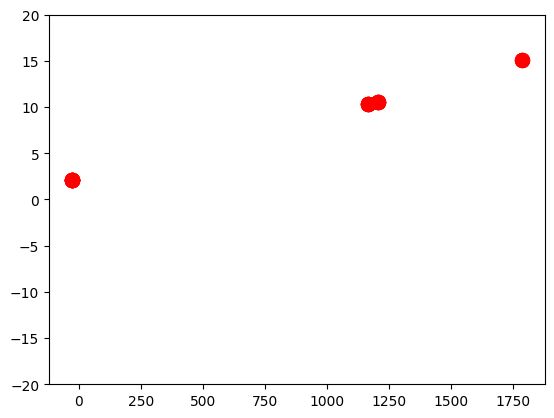

In [124]:
for i in range(3,4): 
    for j in range(len(y_true[i])):
        if(y_true[i][j]==1):
            # print(x_true[i][j])
            plt.scatter(zy_hit[i],y_hit[i],color='red',marker='o',s=100)     
    plt.ylim(-20,20)
    plt.show()

/tmp/ipykernel_27357/3934160041.py:8: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(zx_vec_trad[i], x_vec_trad[i], xerr=0,yerr=dx_vec_trad[i],marker='o',fmt='o',ecolor='black',color='grey',label='data point')


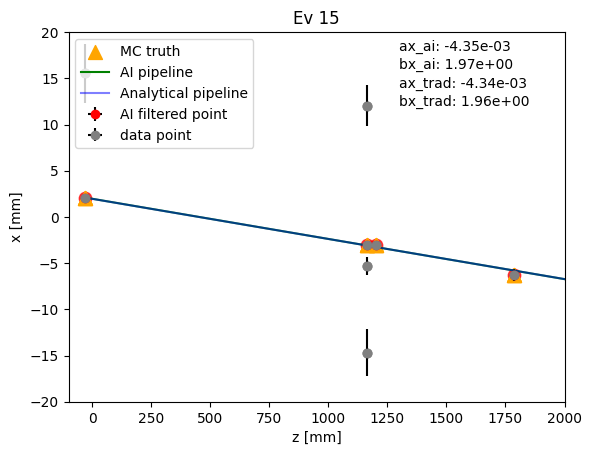

In [43]:
x = np.linspace(-35, 2000, 4)  
x_trad=np.linspace(-35, 2000, 4)  
for i in range(15,16): # 
    # if(chi2_ev[i]>10):
    plt.scatter(zx_hit[i],x_hit[i],color='red',s=80,alpha=0.7) 
    plt.scatter(zx_vec_trad[i],x_vec_trad[i],color='grey',s=40) 
    plt.errorbar(zx_hit[i], x_hit[i], xerr=0,yerr=dx_hit[i],fmt='o',ecolor='black',color='red',label='AI filtered point',)
    plt.errorbar(zx_vec_trad[i], x_vec_trad[i], xerr=0,yerr=dx_vec_trad[i],marker='o',fmt='o',ecolor='black',color='grey',label='data point')  
    mc_truth_added = False
    for j in range(len(x_true[i])):
        if x_true[i][j] == 1 and not mc_truth_added:  # Assicura che solo il primo punto MC truth abbia l'etichetta
            plt.scatter(zx_hit[i], x_hit[i], color='orange', marker='^', s=100, label='MC truth')
            mc_truth_added = True  # Imposta il flag a True dopo aver aggiunto l'etichetta
        elif x_true[i][j] == 1:
            plt.scatter(zx_hit[i], x_hit[i], color='orange', marker='^', s=100)
       
    plt.ylim(-20,20) 
    plt.xlim(-100,2000)
    y=ax_ev[i]*x+bx_ev[i] 
    y_trad=ax_vec_trad[i]*x_trad+bx_vec_trad[i] 
    plt.plot(x, y,label='AI pipeline',color='green',marker=None) 
    plt.plot(x_trad, y_trad, label='Analytical pipeline',color='blue',marker=None,alpha=0.5) 
    plt.ylim(-20,20) 
    ax_rounded = '{:.2e}'.format(ax_ev[i])
    bx_rounded = '{:.2e}'.format(bx_ev[i])
    ax_rounded_trad = '{:.2e}'.format(ax_vec_trad[i])
    bx_rounded_trad = '{:.2e}'.format(bx_vec_trad[i])
    plt.ylabel('x [mm]') 
    plt.xlabel('z [mm]') 
    plt.text( 1300,18,f'ax_ai: {ax_rounded}', fontsize=10)
    plt.text(1300, 16, f'bx_ai: {bx_rounded}', fontsize=10) 
    plt.text( 1300,14,f'ax_trad: {ax_rounded_trad}', fontsize=10)
    plt.text(1300, 12, f'bx_trad: {bx_rounded_trad}', fontsize=10)         
    plt.legend(loc='upper left')
    # plt.xlim(-100,2000) 
    # plt.ylim(-20,20) 
    plt.title(f'Ev {i}') 
    # print(dx_hit[i]) 
    # print(x_hit[i]) 
     # Rimuovi la linea che unisce i punti
    
    plt.xlim(-100,2000) 
    plt.ylim(-20,20)
    # plt.savefig(f'/lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_img_fit/otimized_sageconv/Sim_ev_xzHN{i}.png')      
    plt.show()

In [48]:
hax=ROOT.TH1F("hax","hax",100,-0.1,0.1)
hax.GetXaxis().SetTitle('ax')
hax.GetYaxis().SetTitle('Entries')
hax.SetTitle('ax distribution')
hax.SetLineColor(ROOT.kGreen+3)
hax.SetMarkerColor(ROOT.kGreen+3)
hax_Trad=ROOT.TH1F("hax_Trad","hax_Trad",100,-0.1,0.1)
hax_Trad.GetXaxis().SetTitle('ax')
hax_Trad.GetYaxis().SetTitle('Entries')
hax_Trad.SetLineColor(4)
hax_Trad.SetMarkerColor(4)
hax_Trad.SetTitle('ax distribution analytical pipeline')
for i in range(0,len(ax_ev)):      
    hax.Fill(ax_ev[i])    

for i in range(0,len(ax_vec_trad)):
    hax_Trad.Fill(ax_vec_trad[i])
dict_ax={'ax':hax,'ax_trad':hax_Trad}
root_function.draw_mult_stack(dict_ax,'Angular coefficient distribution in xz view',img_name='ax2',path='/lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_img_fit/balanced_sageconv_hn/')
# cax=ROOT.TCanvas("cax","cax")
# cax.cd()
# hax.Draw()
# hax_Trad.Draw("SAME")
# legendax = ROOT.TLegend(0.1, 0.9, 0.4, 0.8)
# legendax.AddEntry(hax, "AI pipeline", "l")
# legendax.AddEntry(hax_Trad, "Analytical pipeline", "l")
# legendax.Draw()

# cax.SetLogy()
# cax.Draw()   
# cax.SaveAs(f'/lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_img_fit/optimized_gcn/ax.png')

Warning in <TROOT::Append>: Replacing existing TH1: hax (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hax_Trad (Potential memory leak).
Info in <TCanvas::Print>: png file /lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_img_fit/balanced_sageconv_hn//ax2.png has been created


In [49]:
hbx=ROOT.TH1F("hbx","hbx",200,-20,20)
hbx.GetXaxis().SetTitle('bx')
hbx.GetYaxis().SetTitle('Entries')
hbx.SetTitle('bx distribution')
hbx.SetLineColor(ROOT.kGreen+3)
hbx.SetMarkerColor(ROOT.kGreen+3)
hbx_trad=ROOT.TH1F("hbx_trad","hbx_trad",200,-20,20)
hbx_trad.GetXaxis().SetTitle('bx')
hbx_trad.GetYaxis().SetTitle('Entries')
hbx_trad.SetLineColor(4)
hbx_trad.SetMarkerColor(4)
hbx_trad.SetTitle('bx distribution analytical pipeline')
for i in range(0,len(bx_ev)):      
    hbx.Fill(bx_ev[i])   
for i in range(0,len(bx_vec_trad)):      
    hbx_trad.Fill(bx_vec_trad[i])   
dict_bx={'bx':hbx,'bx_trad':hbx_trad}
root_function.draw_mult_stack(dict_bx,'Intercept distribution in xz view',img_name='bx2',path='/lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_img_fit/balanced_sageconv_hn/')
    
# cbx=ROOT.TCanvas("cbx","cbx")
# cbx.cd()
# hbx.Draw()
# hbx_trad.Draw("SAME")
# legendbx = ROOT.TLegend(0.1, 0.9, 0.4, 0.8)
# legendbx.AddEntry(hbx, "AI pipeline", "l")
# legendbx.AddEntry(hbx_trad, "Analytical pipeline", "l")
# legendbx.Draw()
# cbx.SetLogy()
# cbx.Draw()  
# cbx.SaveAs(f'/lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_img_fit/optimized_gcn/bx.png')


Warning in <TROOT::Append>: Replacing existing TH1: hbx (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hbx_trad (Potential memory leak).
Info in <TCanvas::Print>: png file /lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_img_fit/balanced_sageconv_hn//bx2.png has been created


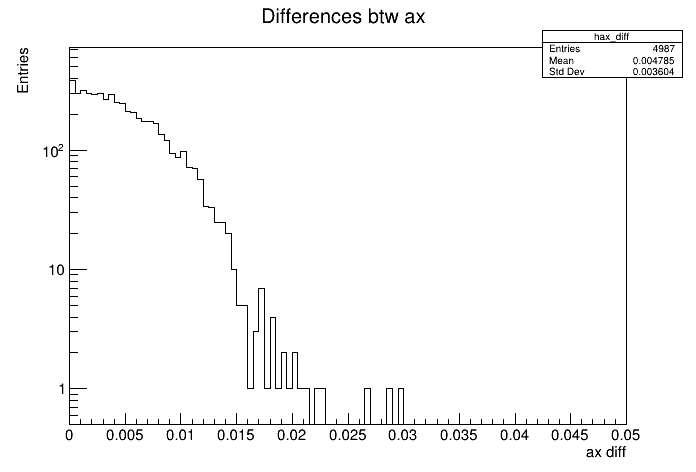

In [30]:
####bx difference between bx from trad and AI pipeline
hax_diff=ROOT.TH1F("hax_diff","hax_diff",100,0,0.05)
hax_diff.GetXaxis().SetTitle('ax diff')
hax_diff.GetYaxis().SetTitle('Entries')
hax_diff.SetTitle('Differences btw ax')
hax_diff.SetLineColor(1)
for i in range(0,len(ax_ev)):      
    hax_diff.Fill(abs(ax_ev[i]-ax_vec_trad[i]) ) 

cax_diff=ROOT.TCanvas("cax_diff","cax_diff")
cax_diff.cd()
hax_diff.Draw()


cax_diff.SetLogy()
cax_diff.Draw()   
# cax_diff.SaveAs(f'/lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_img_fit/otimized_sageconv/ax_diff_sageHN.png')

Info in <TCanvas::Print>: png file /lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_img_fit/otimized_sageconv/bx_diff_sagenorm.png has been created


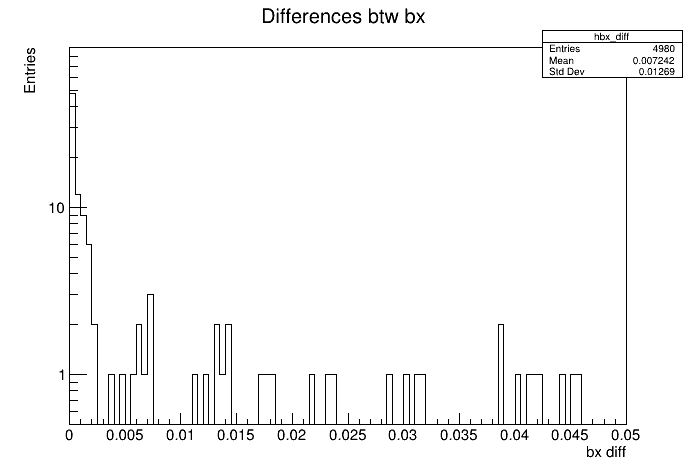

In [28]:
####ax difference between ax from trad and AI pipeline
hbx_diff=ROOT.TH1F("hbx_diff","hbx_diff",100,0,0.05)
hbx_diff.GetXaxis().SetTitle('bx diff')
hbx_diff.GetYaxis().SetTitle('Entries')
hbx_diff.SetTitle('Differences btw bx')
hbx_diff.SetLineColor(1)
for i in range(0,len(bx_ev)):      
    hbx_diff.Fill(abs(bx_ev[i]-bx_vec_trad[i]) ) 

cbx_diff=ROOT.TCanvas("cbx_diff","cbx_diff")
cbx_diff.cd()
hbx_diff.Draw()


cbx_diff.SetLogy()
cbx_diff.Draw()   
# cbx_diff.SaveAs(f'/lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_img_fit/otimized_sageconv/bx_diff_sagenorm.png')

In [50]:
chi2y_ev=[]
hchiy=ROOT.TH1F("hchiy","hchiy",100,-0.5,999.5)
hchiy.GetXaxis().SetTitle('#chi^{2}')
hchiy.GetYaxis().SetTitle('Entries')
hchiy.SetTitle('#chi^{2} distribution (yz view)')
hchiy.SetLineColor(ROOT.kGreen+3)
hchiy.SetMarkerColor(ROOT.kGreen+3)
hchiy_trad=ROOT.TH1F("hchiy_trad","hchiy_trad",100,-0.5,999.5)
hchiy_trad.GetXaxis().SetTitle('#chi^{2}')
hchiy_trad.GetYaxis().SetTitle('Entries')
hchiy_trad.SetTitle('#chi^{2} distribution (yz view) analytical pipeline')
hchiy_trad.SetLineColor(4)
hchiy_trad.SetMarkerColor(4)
for i in range(0,len(ay_ev)):
    chi2_y=0.0
    for j in range(0,len(y_hit[i])):
        chi2_y += ROOT.TMath.Power((y_hit[i][j] - ay_ev[i] * zy_hit[i][j]- by_ev[i]) / dy_hit[i][j], 2);
    hchiy.Fill(chi2_y)    
    if chi2_y>2000 and chi2_y<3000:
        print('bad_ev ',i, chi2_y)
    chi2y_ev.append(chi2_y)
for ch in chi2y_vec_trad:
    hchiy_trad.Fill(ch)
dict_chiy={'hchiy':hchiy,'hchiy_trad':hchiy_trad}
root_function.draw_mult_stack(dict_chiy,'#chi^{2} distribution in yz view',img_name='chiy2',path='/lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_img_fit/balanced_sageconv_hn/')

# c1=ROOT.TCanvas("c1","c1")
# c1.cd()
# hchiy.Draw()
# hchiy_trad.Draw("SAME")
# legend = ROOT.TLegend(0.1, 0.9, 0.4, 0.8)
# legend.AddEntry(hchiy, "AI pipeline", "l")
# legend.AddEntry(hchiy_trad, "Analytical pipeline", "l")
# legend.Draw()

# c1.SetLogy()
# c1.Draw()
# c1.SaveAs(f'/lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_img_fit/optimized_gcn/chi2_viewyz_sim.png')

bad_ev  1169 2362.689912266644
bad_ev  2233 2868.0487559727108
bad_ev  3080 2788.936395038065


Warning in <TROOT::Append>: Replacing existing TH1: hchiy (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hchiy_trad (Potential memory leak).
Info in <TCanvas::Print>: png file /lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_img_fit/balanced_sageconv_hn//chiy2.png has been created


/tmp/ipykernel_27357/3724384300.py:8: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  plt.errorbar(zy_vec_trad[i], y_vec_trad[i], xerr=0,yerr=dy_vec_trad[i],marker='o',fmt='o',ecolor='black',color='grey',label='data point')


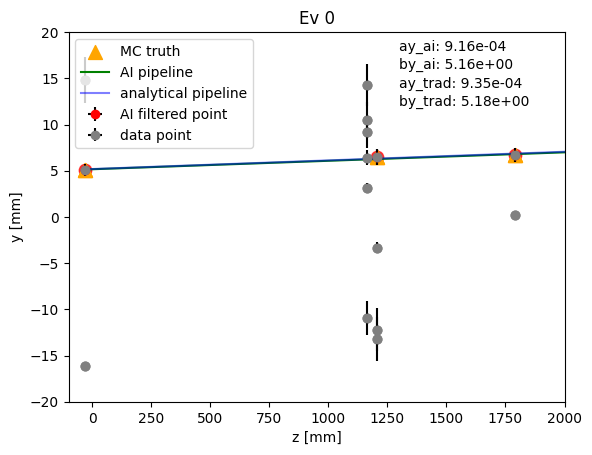

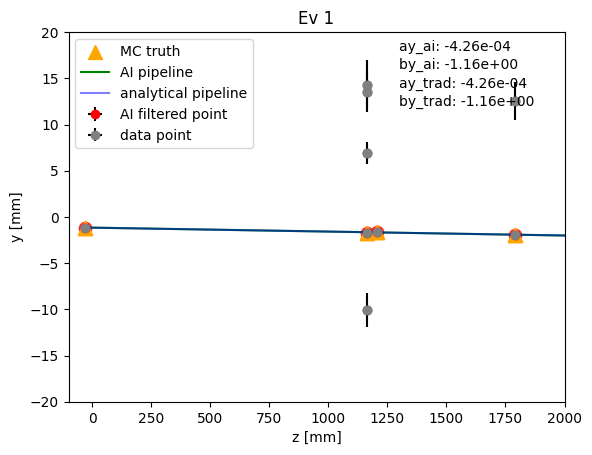

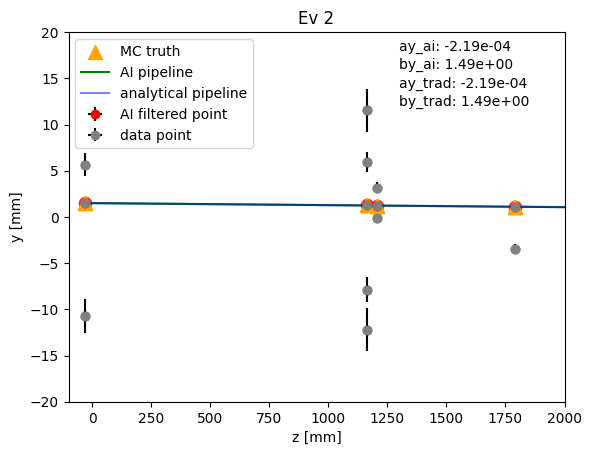

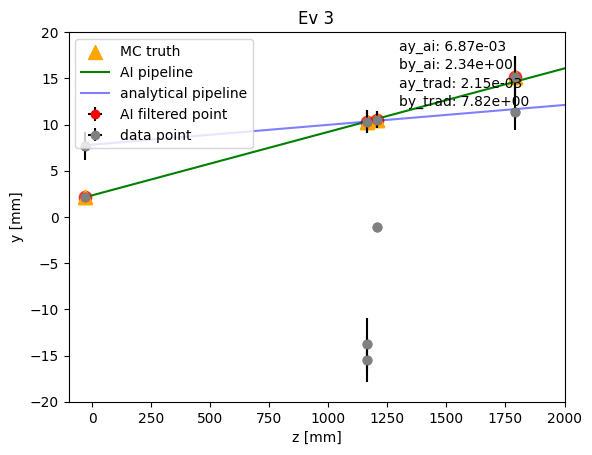

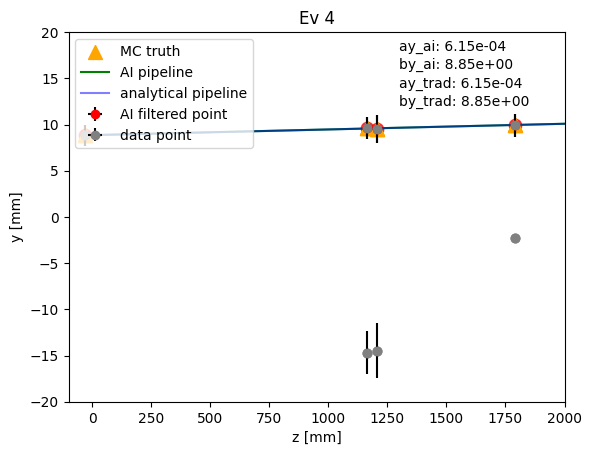

In [23]:
z= np.linspace(-35, 2000, 4)  
z_trad=np.linspace(-35, 2000, 4)  
for i in range(0,5): # 
    # if(chi2_ev[i]>10):
    plt.scatter(zy_hit[i],y_hit[i],color='red',s=80,alpha=0.7) 
    plt.scatter(zy_vec_trad[i],y_vec_trad[i],color='grey',s=40) 
    plt.errorbar(zy_hit[i], y_hit[i], xerr=0,yerr=dy_hit[i],fmt='o',ecolor='black',color='red',label='AI filtered point',)
    plt.errorbar(zy_vec_trad[i], y_vec_trad[i], xerr=0,yerr=dy_vec_trad[i],marker='o',fmt='o',ecolor='black',color='grey',label='data point')
    mc_truth_added = False
    for j in range(len(y_true[i])):
        if y_true[i][j] == 1 and not mc_truth_added:  # Assicura che solo il primo punto MC truth abbia l'etichetta
            plt.scatter(zy_hit[i],y_hit[i], color='orange', marker='^', s=100, label='MC truth')
            mc_truth_added = True  # Imposta il flag a True dopo aver aggiunto l'etichetta
        elif y_true[i][j] == 1:
            plt.scatter(zy_hit[i], y_hit[i], color='orange', marker='^', s=100)

    plt.ylim(-20,20) 
    plt.xlim(-100,2000)
    y=ay_ev[i]*z+by_ev[i] 
    y_trad=ay_vec_trad[i]*z_trad+by_vec_trad[i] 
    plt.plot(z, y,label='AI pipeline',color='green',marker=None) 
    plt.plot(z_trad, y_trad, label='analytical pipeline',color='blue',marker=None,alpha=0.5) 
    plt.ylim(-20,20) 
    ay_rounded = '{:.2e}'.format(ay_ev[i])
    by_rounded = '{:.2e}'.format(by_ev[i])
    ay_rounded_trad = '{:.2e}'.format(ay_vec_trad[i])
    by_rounded_trad = '{:.2e}'.format(by_vec_trad[i])
    plt.ylabel('y [mm]') 
    plt.xlabel('z [mm]') 
    plt.text( 1300,18,f'ay_ai: {ay_rounded}', fontsize=10)
    plt.text(1300, 16, f'by_ai: {by_rounded}', fontsize=10) 
    plt.text( 1300,14,f'ay_trad: {ay_rounded_trad}', fontsize=10)
    plt.text(1300, 12, f'by_trad: {by_rounded_trad}', fontsize=10)         
    plt.legend(loc='upper left')
    # plt.xlim(-100,2000) 
    # plt.ylim(-20,20) 
    plt.title(f'Ev {i}') 
    # print(dx_hit[i]) 
    # print(x_hit[i]) 
     # Rimuovi la linea che unisce i punti
    
    plt.xlim(-100,2000) 
    plt.ylim(-20,20)
    # plt.savefig(f'/lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_img_fit/otimized_sageconv/Sim_ev_yzHN{i}.png')      
    plt.show()
   

In [51]:
hay=ROOT.TH1F("hay","hay",100,-0.1,0.1)
hay.GetXaxis().SetTitle('ay')
hay.GetYaxis().SetTitle('Entries')
hay.SetTitle('ay distribution')
hay.SetLineColor(ROOT.kGreen+3)
hay.SetMarkerColor(ROOT.kGreen+3)
hay_trad=ROOT.TH1F("hay_trad","hay_trad",100,-0.1,0.1)
hay_trad.GetXaxis().SetTitle('ay')
hay_trad.GetYaxis().SetTitle('Entries')
hay_trad.SetTitle('ay distribution analytical distribution (yz view)')
hay_trad.SetLineColor(4)
hay_trad.SetMarkerColor(4)
for i in range(0,len(ay_ev)):      
    hay.Fill(ay_ev[i])    
for i in range(0,len(ay_vec_trad)):
    hay_trad.Fill(ay_vec_trad[i])

dict_ay={'ay':hay,'ay_trad':hay_trad}
root_function.draw_mult_stack(dict_ay,'Angular coefficient distribution in yz view',img_name='ay2',path='/lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_img_fit/balanced_sageconv_hn/')

# cay=ROOT.TCanvas("cay","cay")
# cay.cd()
# hay.Draw()
# hay_trad.Draw("SAME")
# legenday = ROOT.TLegend(0.1, 0.9, 0.4, 0.8)
# legenday.AddEntry(hay, "AI pipeline", "l")
# legenday.AddEntry(hay_trad, "Analytical pipeline", "l")
# legenday.Draw()

# cay.SetLogy()
# cay.Draw()   
# cay.SaveAs(f'/lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_img_fit/optimized_gcn/cay.png')

Warning in <TROOT::Append>: Replacing existing TH1: hay (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hay_trad (Potential memory leak).
Info in <TCanvas::Print>: png file /lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_img_fit/balanced_sageconv_hn//ay2.png has been created


Info in <TCanvas::Print>: png file /lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_img_fit/otimized_sageconv/ay_diff_sageHN.png has been created


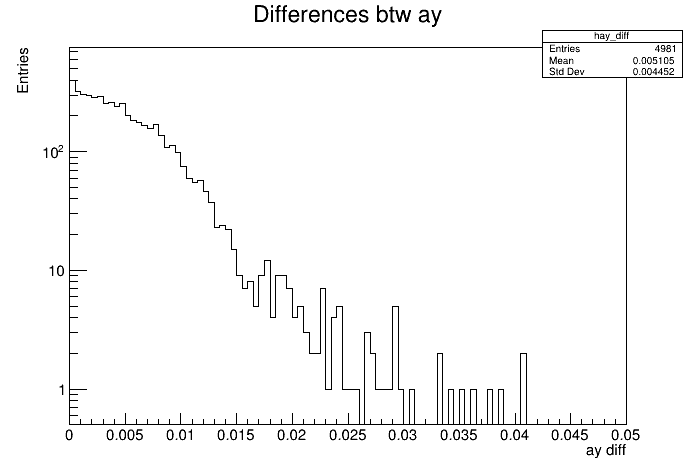

In [45]:
####ay difference between bx from trad and AI pipeline
hay_diff=ROOT.TH1F("hay_diff","hay_diff",100,0,0.05)
hay_diff.GetXaxis().SetTitle('ay diff')
hay_diff.GetYaxis().SetTitle('Entries')
hay_diff.SetTitle('Differences btw ay')
hay_diff.SetLineColor(1)
for i in range(0,len(ay_ev)):      
    hay_diff.Fill(abs(ay_ev[i]-ay_vec_trad[i]) ) 

cay_diff=ROOT.TCanvas("cay_diff","cay_diff")
cay_diff.cd()
hay_diff.Draw()


cay_diff.SetLogy()
cay_diff.Draw()   
# cay_diff.SaveAs(f'/lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_img_fit/otimized_sageconv/ay_diff_sageHN.png')

In [52]:
hby=ROOT.TH1F("hby","hby",100,-20,20)
hby.GetXaxis().SetTitle('by')
hby.GetYaxis().SetTitle('Entries')
hby.SetTitle('by distribution')
hby.SetLineColor(ROOT.kGreen+3)
hby.SetMarkerColor(ROOT.kGreen+3)
hby_trad=ROOT.TH1F("hby_trad","hby_trad",100,-20,20)
hby_trad.GetXaxis().SetTitle('by')
hby_trad.GetYaxis().SetTitle('Entries')
hby_trad.SetTitle('by distribution analytical pipeline (yz view)')
hby_trad.SetLineColor(4)
hby_trad.SetMarkerColor(4)
for i in range(0,len(by_ev)):      
    hby.Fill(by_ev[i])    
for i in range(0,len(by_vec_trad)):      
    hby_trad.Fill(by_vec_trad[i])    
dict_by={'by':hby,'by_trad':hby_trad}
root_function.draw_mult_stack(dict_by,'Intercept distribution in yz view',img_name='by2',path='/lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_img_fit/balanced_sageconv_hn/')

# cby=ROOT.TCanvas("cby","cby")
# cby.cd()
# hby.Draw()
# hby_trad.Draw("SAME")
# legendby = ROOT.TLegend(0.1, 0.9, 0.4, 0.8)
# legendby.AddEntry(hby, "AI pipeline", "l")
# legendby.AddEntry(hby_trad, "Analytical pipeline", "l")
# legendby.Draw()

# cby.SetLogy()
# cby.Draw()
# cby.SaveAs(f'/lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_img_fit/optimized_gcn/cby.png')

Warning in <TROOT::Append>: Replacing existing TH1: hby (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hby_trad (Potential memory leak).
Info in <TCanvas::Print>: png file /lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_img_fit/balanced_sageconv_hn//by2.png has been created


Info in <TCanvas::Print>: png file /lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_img_fit/optimized_gcn/by_diff.png has been created


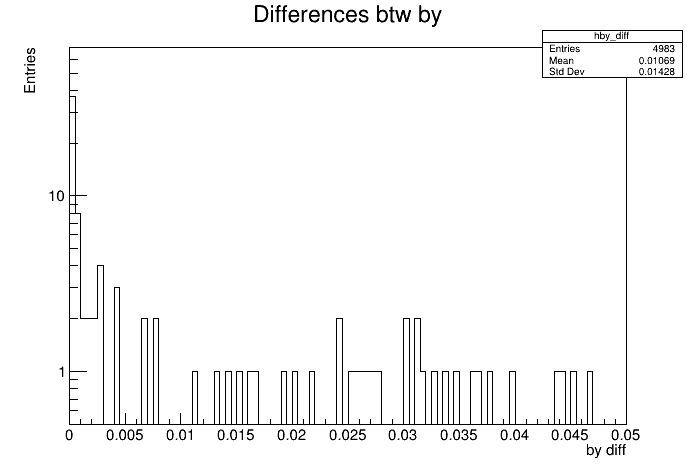

In [30]:
hby_diff=ROOT.TH1F("hby_diff","hby_diff",100,0,0.05)
hby_diff.GetXaxis().SetTitle('by diff')
hby_diff.GetYaxis().SetTitle('Entries')
hby_diff.SetTitle('Differences btw by')
hby_diff.SetLineColor(1)
for i in range(0,len(by_ev)):      
    hby_diff.Fill(abs(by_ev[i]-by_vec_trad[i]) ) 

cby_diff=ROOT.TCanvas("cby_diff","cby_diff")
cby_diff.cd()
hby_diff.Draw()


cby_diff.SetLogy()
cby_diff.Draw()   
# cby_diff.SaveAs(f'/lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_img_fit/optimized_gcn/by_diff.png')

In [10]:
fin='/lustrehome/federicacuna/TB_Sept_2023_ml/Data/simulated/root_data/TB_2023_T10_Sept_pi-Mono_10000_inclined_10000-evt-800.root'
file   = ROOT.TFile(fin)
ptree = file.Get("Primary")
nhit = ptree.GetEntries()

cx_prim=[]
cy_prim=[]
cz_prim=[]
y_prim=[]
x_prim=[]
z_prim=[]

node_df_pi=pd.read_parquet('/lustrehome/federicacuna/TB_Sept_2023_ml/Data/preprocessed/raw/pi-_10GeV_4ly_1e-4_inclined_4ly/TrkData_viewx_cl_TB_2023_T10_Sept_pi-Mono_10000_inclined_10000-evt-800_pitch0.25node_df.parquet')
sel_ev=node_df_pi.Ev.unique()
val_to_remove=np.array(4965)#,1459,3041,3129,4009,4830,4907,4957,1104,4340])
# ev_to_delete_iny=[728,1459,3041,3129,4009,4830,4907,4957]
# ev_to_delete_inx=[1104,4340]
maschera = ~np.isin(sel_ev, val_to_remove)

# Creazione del nuovo array mantenendo solo gli elementi che non devono essere rimossi
sel_ev = sel_ev[maschera]

for i in range(nhit):
    ptree.GetEntry(i)
    if ptree.eventID in sel_ev:
    # print(ptree.eventID)
        xmc = ptree.PrimaryParticlePositionX
        ymc = ptree.PrimaryParticlePositionY
        zmc = ptree.PrimaryParticlePositionZ
        primary_PDG=ptree.PrimaryParticlePDG
        cx = ptree.PrimaryParticleDirectionX
        cy = ptree.PrimaryParticleDirectionY
        cz = ptree.PrimaryParticleDirectionZ
        x_prim.append(xmc)
        y_prim.append(ymc)
        z_prim.append(zmc)
        
        cx_prim.append(cx)
        cy_prim.append(cy)
        cz_prim.append(cz)


Info in <TCanvas::Print>: png file /lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_img_fit/balanced_sageconv//cx2.png has been created
Info in <TCanvas::Print>: png file /lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_img_fit/balanced_sageconv//cy2.png has been created
Info in <TCanvas::Print>: png file /lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_img_fit/balanced_sageconv//cz2.png has been created


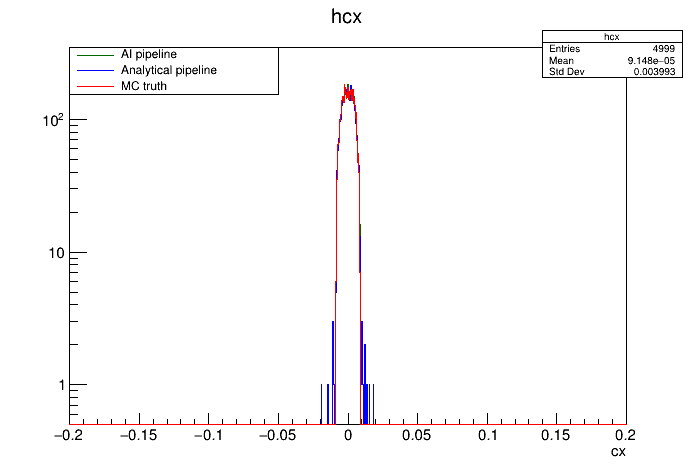

In [11]:
#####plot cosine director
hcx=ROOT.TH1F("hcx","hcx",1000,-0.2,0.2)
hcx.SetLineColor(ROOT.kGreen+3)
hcx.SetMarkerColor(ROOT.kGreen+3)
hcx.GetXaxis().SetTitle("cx")

hcx_trad=ROOT.TH1F("hcx_trad","hcx_trad",1000,-0.2,0.2)
hcx_trad.SetMarkerColor(4)
hcx_trad.SetLineColor(4)

hcx_prim=ROOT.TH1F("hcx_prim","hcx_prim",1000,-0.2,0.2)
hcx_prim.SetLineColor(2)
hcx_prim.SetMarkerColor(2)

hcy=ROOT.TH1F("hcy","hcy",1000,-0.2,0.2)
hcy.SetLineColor(ROOT.kGreen+3)
hcy.SetMarkerColor(ROOT.kGreen+3)
hcy.GetXaxis().SetTitle("cy")

hcy_trad=ROOT.TH1F("hcy_trad","hcy_trad",1000,-0.2,0.2)
hcy_trad.SetLineColor(4)
hcy_trad.SetMarkerColor(4)

hcy_prim=ROOT.TH1F("hcy_prim","hcy_prim",1000,-0.2,0.2)
hcy_prim.SetLineColor(2)
hcy_prim.SetMarkerColor(2)

hcz=ROOT.TH1F("hcz","hcz",100,0.9996,1.0001)
hcz.GetXaxis().SetTitle("cz")
hcz.SetLineColor(ROOT.kGreen+3)
hcz.SetMarkerColor(ROOT.kGreen+3)

hcz_trad=ROOT.TH1F("hcz_trad","hcz_trad",100,0.9996,1.0001)
hcz_trad.SetLineColor(4)
hcz_trad.SetMarkerColor(4)

hcz_prim=ROOT.TH1F("hcz_prim","hcz_prim",100,0.9996,1.0001)
hcz_prim.SetLineColor(2)
hcz_prim.SetMarkerColor(2)

for j in range(len(crx)):
    hcx.Fill(crx[j])
    
for i in range(len(crx_trad)):
    hcx_trad.Fill(crx_trad[i])
    hcx_prim.Fill(cx_prim[i])

for j in range(len(cry)):
     hcy.Fill(cry[j])

for i in range(len(cry_trad)):  
    hcy_trad.Fill(cry_trad[i])
    hcy_prim.Fill(cy_prim[i])
    
for j in range(len(crz)):
    hcz.Fill(crz[j])
    
for i in range(len(crz_trad)):
    hcz_trad.Fill(crz_trad[i])
    hcz_prim.Fill(cz_prim[i])


    
dict_cx={'hcx':hcx,'hcx_trad':hcx_trad,'hcx_prim':hcx_prim}
root_function.draw_mult_stack(dict_cx,'cx distribution',img_name='cx2',path='/lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_img_fit/balanced_sageconv/')
dict_cy={'hcy':hcy,'hcy_trad':hcy_trad,'hcy_prim':hcy_prim}
root_function.draw_mult_stack(dict_cy,'cy distribution',img_name='cy2',path='/lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_img_fit/balanced_sageconv/')
dict_cz={'hcz':hcz,'hcz_trad':hcz_trad,'hcz_prim':hcz_prim}
root_function.draw_mult_stack(dict_cz,'cz distribution',img_name='cz2',path='/lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_img_fit/balanced_sageconv/')

c_cx=ROOT.TCanvas("c_cx","c_cx")
c_cx.cd()
hcx.Draw()
hcx_trad.Draw("SAME")
hcx_prim.Draw("SAME")
legendcx = ROOT.TLegend(0.1, 0.9, 0.4, 0.8)
legendcx.AddEntry(hcx, "AI pipeline", "l")
legendcx.AddEntry(hcx_trad, "Analytical pipeline", "l")
legendcx.AddEntry(hcx_prim, "MC truth", "l")
legendcx.Draw()
c_cx.SetLogy()
c_cx.Draw()

# c_cy=ROOT.TCanvas("c_cy","c_cy")
# c_cy.cd()
# hcy.Draw()
# hcy_trad.Draw("SAME")
# hcy_prim.Draw("SAME")
# legendcy = ROOT.TLegend(0.1, 0.9, 0.4, 0.8)
# legendcy.AddEntry(hcy, "AI pipeline", "l")
# legendcy.AddEntry(hcy_trad, "Analytical pipeline", "l")
# legendcy.AddEntry(hcy_prim, "MC truth", "l")
# legendcy.Draw()
# c_cy.SetLogy()
# c_cy.Draw()

# c_cz=ROOT.TCanvas("c_cz","c_cz")
# c_cz.cd()
# hcz.Draw()
# hcz_trad.Draw("SAME")
# hcz_prim.Draw("SAME")
# legendcz = ROOT.TLegend(0.1, 0.9, 0.4, 0.8)
# legendcz.AddEntry(hcz, "AI pipeline", "l")
# legendcz.AddEntry(hcz_trad, "Analytical pipeline", "l")
# legendcz.AddEntry(hcz_prim, "MC truth", "l")
# legendcz.Draw()
# c_cz.SetLogy()
# c_cz.Draw()
# c_cx.SaveAs(f'/lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_img_fit/optimized_gcn/c_cx.png')
# c_cy.SaveAs(f'/lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_img_fit/optimized_gcn/c_cy.png')
# c_cz.SaveAs(f'/lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_img_fit/optimized_gcn/c_cz.png')

In [12]:
###residuals
res_cx_ai=[]
res_cy_ai=[]
res_cz_ai=[]
res_cx_trad=[]
res_cy_trad=[]
res_cz_trad=[]
for i in range(len(crx)):
    try:
        res_cx_ai.append(abs(crx[i]-cx_prim[i]))
        res_cy_ai.append(abs(cry[i]-cy_prim[i]))
        res_cz_ai.append(abs(crz[i]-cz_prim[i]))
        res_cx_trad.append(abs(crx_trad[i]-cx_prim[i]))
        # if(abs(crx_trad[i]-cx_prim[i])<=0.00001):
        #     print('take a look ',i, crx_trad[i], cx_prim[i] )
        res_cy_trad.append(abs(cry_trad[i]-cy_prim[i]))
        res_cz_trad.append(abs(crz_trad[i]-cz_prim[i]))
    except IndexError:
        continue
    
    

Info in <TCanvas::Print>: png file /lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_img_fit/balanced_sageconv_hn//diff_cx_2.png has been created


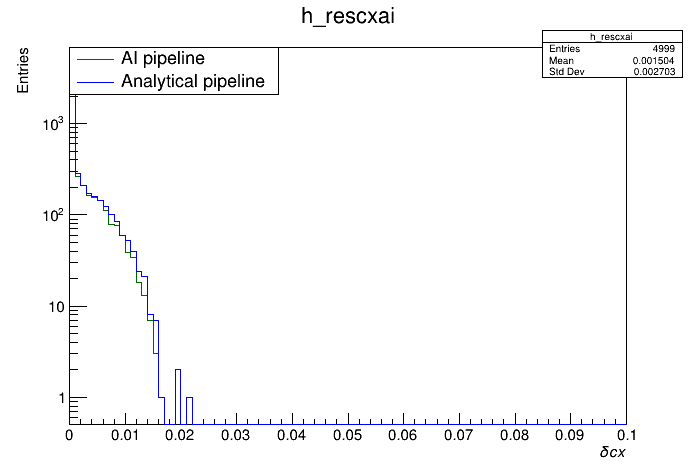

In [13]:
h_rescxai=ROOT.TH1F("h_rescxai","h_rescxai",100,0,0.1)
h_rescxai.SetLineColor(ROOT.kGreen+3)
h_rescxai.SetMarkerColor(ROOT.kGreen+3)

h_rescxtrad=ROOT.TH1F("h_rescxtrad","h_rescxtrad",100,0,0.1)
h_rescxtrad.SetLineColor(4)
h_rescxtrad.SetMarkerColor(4)

h_rescxtrad.GetXaxis().SetTitle('$\delta cx')
h_rescxtrad.GetYaxis().SetTitle('Entries')
h_rescxai.GetXaxis().SetTitle('$\delta cx')
h_rescxai.GetYaxis().SetTitle('Entries')

for i in range(len(res_cx_ai)):
    h_rescxai.Fill(res_cx_ai[i])
    
for i in range(len(res_cx_trad)):    
    h_rescxtrad.Fill(res_cx_trad[i])


c_rescxai=ROOT.TCanvas("c_rescxai","c_rescxai")
c_rescxai.cd()
h_rescxai.Draw()
h_rescxtrad.Draw("SAME")
legendresx = ROOT.TLegend(0.1, 0.9, 0.4, 0.8)
legendresx.AddEntry(h_rescxai, "AI pipeline", "l")
legendresx.AddEntry(h_rescxtrad, "Analytical pipeline", "l")
legendresx.Draw()
c_rescxai.SetLogy()
c_rescxai.Draw()

# c_rescxai.SaveAs(f'/lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_img_fit/optimized_gcn/c_rescxai.png')
dict_rescxai={'h_rescxai':h_rescxai,'h_rescxtrad':h_rescxtrad}
root_function.draw_mult_stack(dict_rescxai,'Difference btw cx',img_name='diff_cx_2',path='/lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_img_fit/balanced_sageconv_hn/')


Info in <TCanvas::Print>: png file /lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_img_fit/balanced_sageconv//diff_cy_2.png has been created


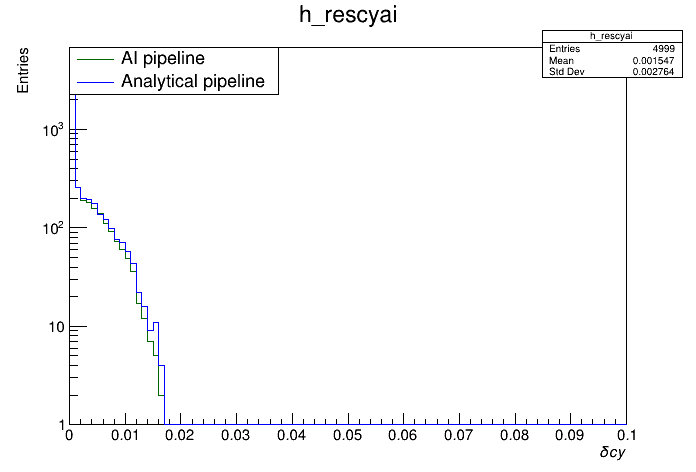

In [14]:
h_rescyai=ROOT.TH1F("h_rescyai","h_rescyai",100,0,0.1)
h_rescyai.SetLineColor(ROOT.kGreen+3)
h_rescyai.SetMarkerColor(ROOT.kGreen+3)
h_rescyai.GetXaxis().SetTitle('$\delta cy')
h_rescyai.GetYaxis().SetTitle('Entries')
h_rescytrad=ROOT.TH1F("h_rescytrad","h_rescytrad",100,0,0.1)
h_rescytrad.SetLineColor(4)
h_rescytrad.SetMarkerColor(4)
h_rescytrad.GetXaxis().SetTitle('$\delta cy')
h_rescytrad.GetYaxis().SetTitle('Entries')

for i in range(len(res_cy_ai)):
    h_rescyai.Fill(res_cy_ai[i])
    h_rescytrad.Fill(res_cy_trad[i])



c_rescyai=ROOT.TCanvas("c_rescyai","c_rescyai")
c_rescyai.cd()
h_rescyai.Draw()
h_rescytrad.Draw("SAME")
legendresy = ROOT.TLegend(0.1, 0.9, 0.4, 0.8)
legendresy.AddEntry(h_rescyai, "AI pipeline", "l")
legendresy.AddEntry(h_rescytrad, "Analytical pipeline", "l")
legendresy.Draw()
c_rescyai.SetLogy()
c_rescyai.Draw()
# c_rescyai.SaveAs(f'/lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_img_fit/optimized_gcn/c_rescyai.png')
dict_rescyai={'h_rescyai':h_rescyai,'h_rescytrad':h_rescytrad}
root_function.draw_mult_stack(dict_rescyai,'Difference btw cy',img_name='diff_cy_2',path='/lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_img_fit/balanced_sageconv/')


Info in <TCanvas::Print>: png file /lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_img_fit/balanced_sageconv//diff_cz_2.png has been created


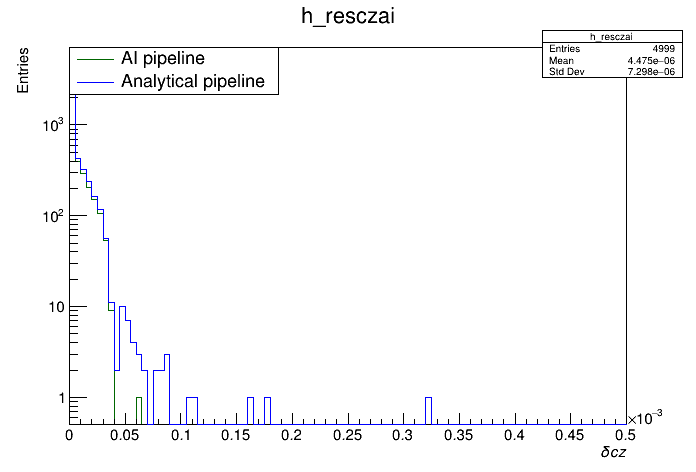

In [15]:
h_resczai=ROOT.TH1F("h_resczai","h_resczai",100,0,0.0005)
h_resczai.SetLineColor(ROOT.kGreen+3)
h_resczai.SetMarkerColor(ROOT.kGreen+3)
h_resczai.GetXaxis().SetTitle('$\delta cz')
h_resczai.GetYaxis().SetTitle('Entries')

h_rescztrad=ROOT.TH1F("h_rescztrad","h_rescztrad",100,0,0.0005)
h_rescztrad.SetLineColor(4)
h_rescztrad.SetMarkerColor(4)
h_rescztrad.GetXaxis().SetTitle('$\delta cz')
h_rescztrad.GetYaxis().SetTitle('Entries')
for i in range(len(res_cz_ai)):
    h_resczai.Fill(res_cz_ai[i])
    h_rescztrad.Fill(res_cz_trad[i])


c_resczai=ROOT.TCanvas("c_resczai","c_resczai")
c_resczai.cd()
h_resczai.Draw()
h_rescztrad.Draw("SAME")
legendresz = ROOT.TLegend(0.1, 0.9, 0.4, 0.8)
legendresz.AddEntry(h_resczai, "AI pipeline", "l")
legendresz.AddEntry(h_rescztrad, "Analytical pipeline", "l")
legendresz.Draw()
c_resczai.SetLogy()
c_resczai.Draw()
# c_resczai.SaveAs(f'/lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_img_fit/optimized_gcn/c_resczai.png')
dict_resczai={'h_resczai':h_resczai,'h_rescztrad':h_rescztrad}
root_function.draw_mult_stack(dict_resczai,'Difference btw cz',img_name='diff_cz_2',path='/lustrehome/federicacuna/TB_Sept_2023_ml/output_gnn_img_fit/balanced_sageconv/')
